In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
BATCH_SIZE = 16
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=10

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r"C:\Users\USER\Downloads\pests",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 6570 files belonging to 7 classes.


In [4]:
class_names = dataset.class_names
class_names

['Tomato_Spider_mites_Two_spotted_spider_mite',
 'cashew_leaf miner',
 'cassava_green mite',
 'maize_fall armyworm',
 'maize_grasshoper',
 'maize_leaf beetle',
 'rice_hispa']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(16, 256, 256, 3)
[4 4 3 4 1 3 0 3 3 3 5 1 4 4 0 3]


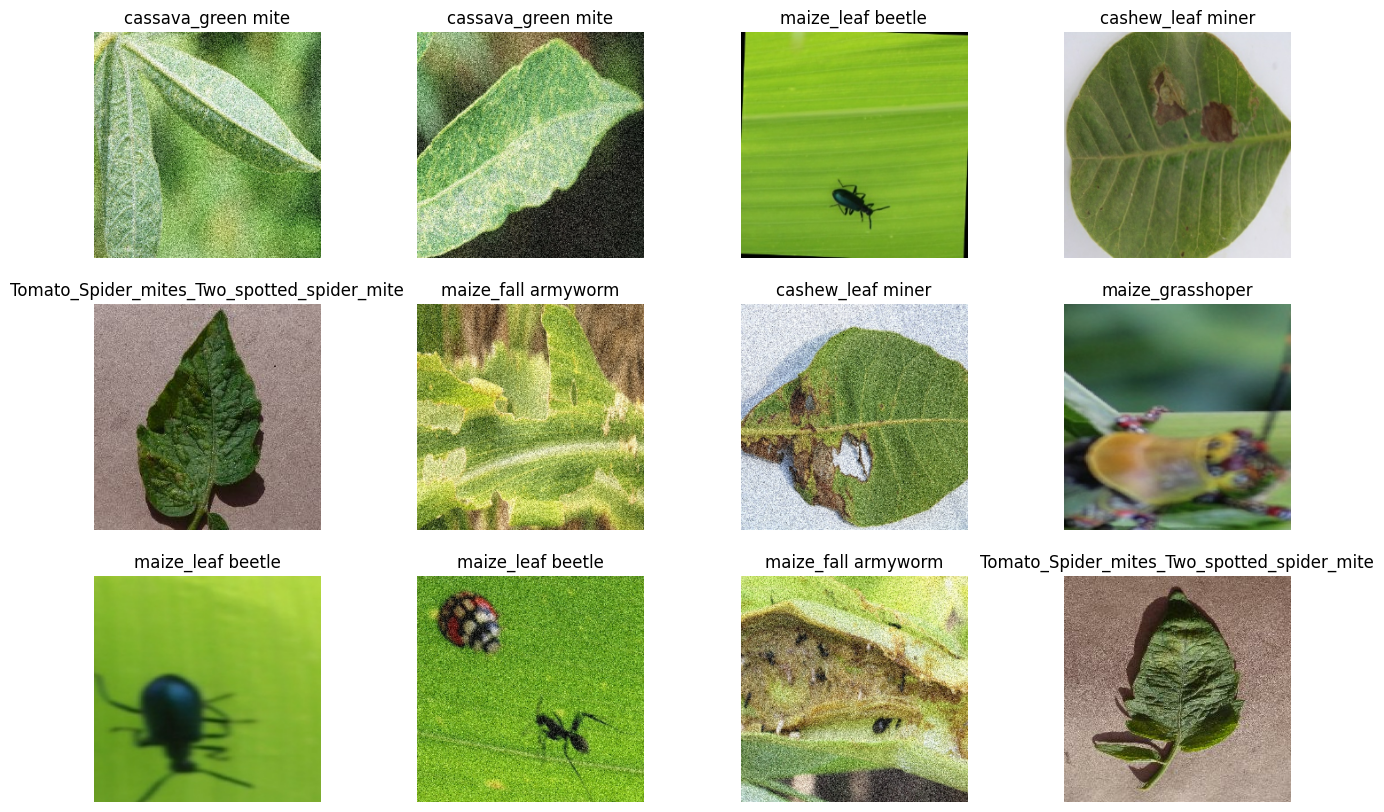

In [6]:
plt.figure(figsize=(16, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

411

In [8]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [10]:
len(train_ds)

328

In [11]:
len(val_ds)

41

In [12]:
len(test_ds)

42

In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [15]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [16]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [17]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 7

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (16, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (16, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (16, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (16, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (16, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (16, 60, 60, 64)         

In [19]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [20]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
328/328 [==============================] - 608s 2s/step - loss: 1.3787 - accuracy: 0.4821 - val_loss: 1.0609 - val_accuracy: 0.6204
Epoch 2/10
328/328 [==============================] - 622s 2s/step - loss: 0.9207 - accuracy: 0.6704 - val_loss: 0.8731 - val_accuracy: 0.6814
Epoch 3/10
328/328 [==============================] - 592s 2s/step - loss: 0.7940 - accuracy: 0.7140 - val_loss: 0.7733 - val_accuracy: 0.7119
Epoch 4/10
328/328 [==============================] - 536s 2s/step - loss: 0.6951 - accuracy: 0.7430 - val_loss: 0.6617 - val_accuracy: 0.7393
Epoch 5/10
328/328 [==============================] - 671s 2s/step - loss: 0.6190 - accuracy: 0.7762 - val_loss: 0.8233 - val_accuracy: 0.7180
Epoch 6/10
328/328 [==============================] - 504s 2s/step - loss: 0.5980 - accuracy: 0.7821 - val_loss: 0.5914 - val_accuracy: 0.7927
Epoch 7/10
328/328 [==============================] - 532s 2s/step - loss: 0.5121 - accuracy: 0.8178 - val_loss: 0.6634 - val_accuracy: 0.7683

In [21]:
scores = model.evaluate(test_ds)

42/42 [==============================] - 35s 323ms/step - loss: 0.4486 - accuracy: 0.8527


In [22]:
scores

[0.4486350417137146, 0.8526785969734192]

In [23]:
history

In [24]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 328}

In [25]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [26]:
type(history.history['loss'])

list

In [27]:
len(history.history['loss'])

10

In [28]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.378745198249817,
 0.9207277894020081,
 0.794021487236023,
 0.6951043605804443,
 0.6189782619476318]

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

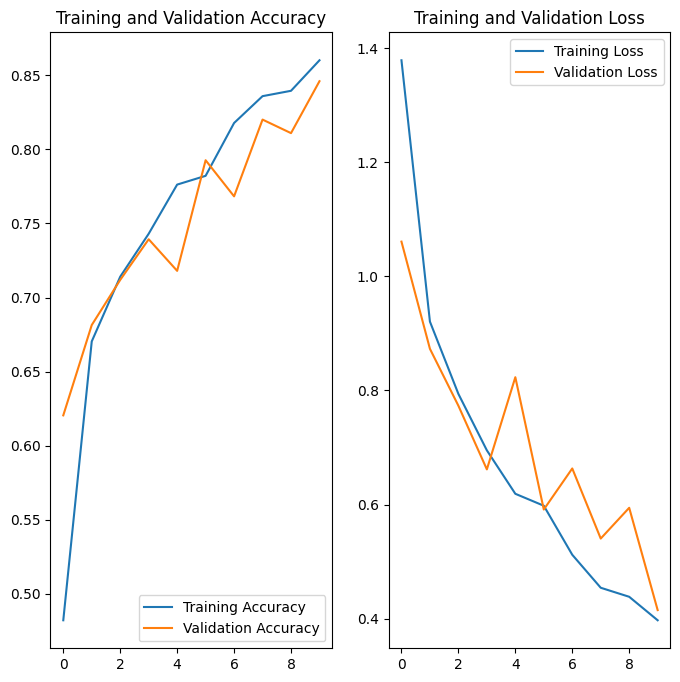

In [30]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: cashew_leaf miner
1/1 [==============================] - 0s 370ms/step
predicted label: cashew_leaf miner


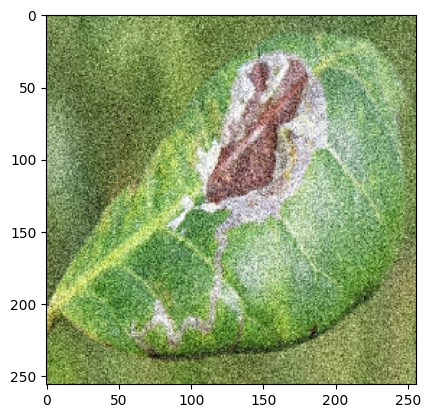

In [35]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [36]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 46ms/step


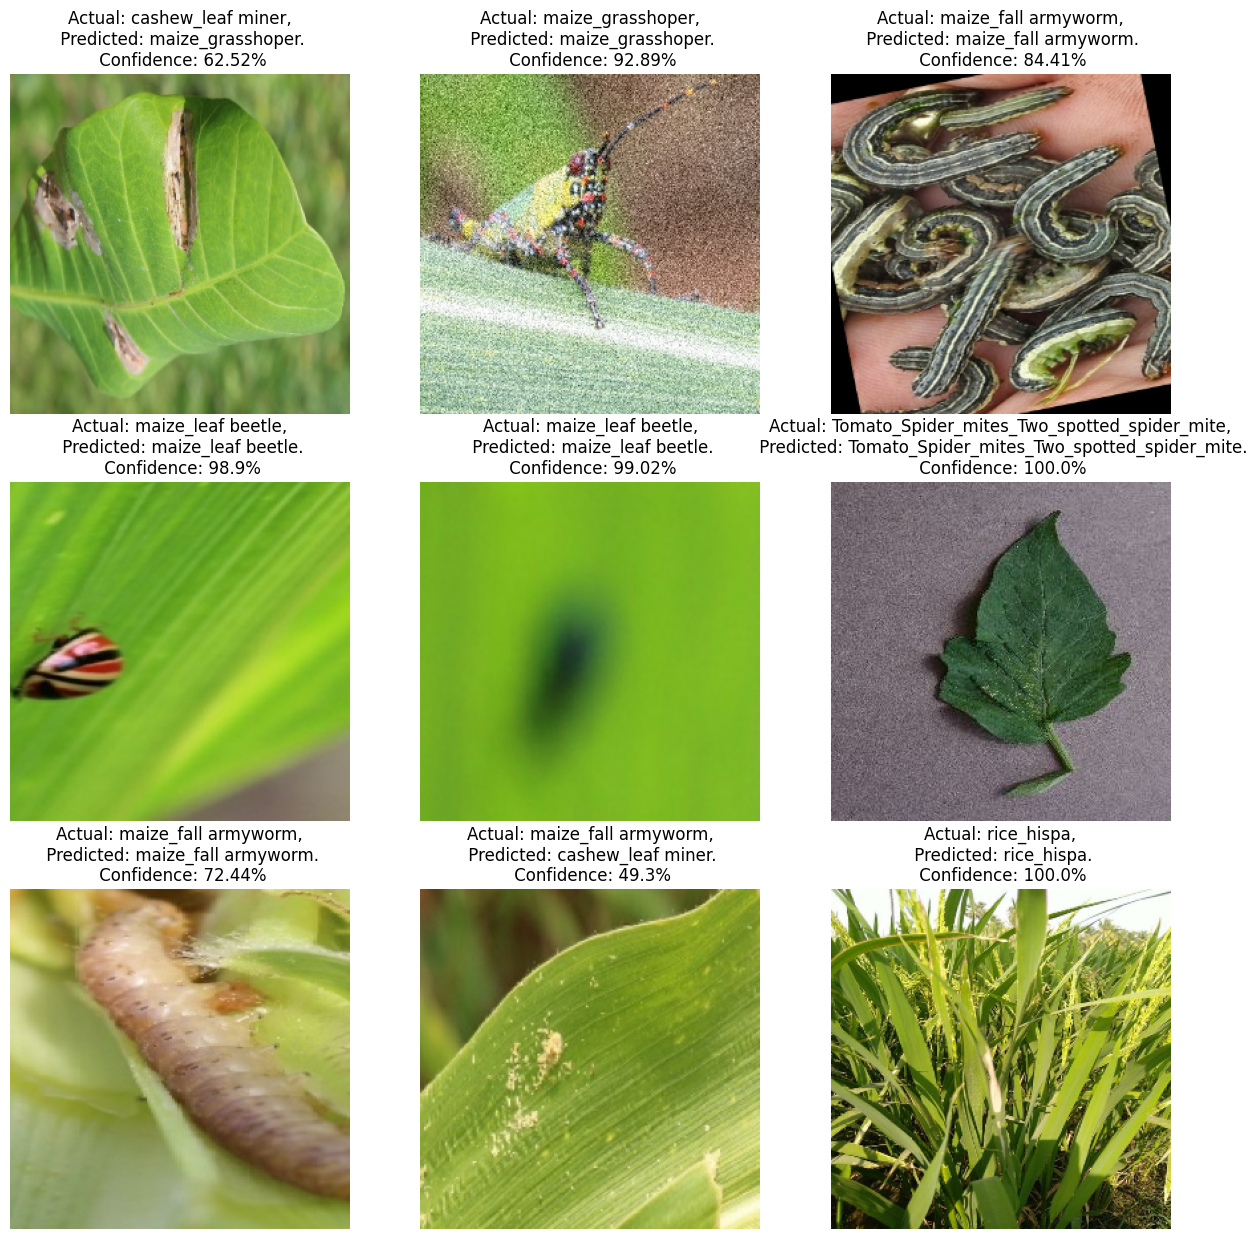

In [33]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [48]:
import os

# Get all directories in "../models"
directories = [d for d in os.listdir("../models") if os.path.isdir(os.path.join("../models", d))]

# Extract numeric parts from directory names
versions = [int(''.join(filter(str.isdigit, d))) for d in directories if any(char.isdigit() for char in d)]

# Find the maximum version number
model_version = max(versions + [0]) + 1

# Save the model
model.save(f"../models/{model_version}/pests.h5")

